In [1]:
from config import CONFIG
from utils import series_to_supervised

CONFIG

{'pair': 'BTC_ETH',
 'period': 300,
 'input_size': 256,
 'output_size': 16,
 'lstm_hidden_size': 50,
 'columns': ['Close', 'Volume', 'Low', 'High'],
 'csv_src_file': 'BTC_ETH',
 'name': 'lstm',
 'folder': {'data': 'data/', 'weights': 'weights/'},
 'filename': 'BTC_ETH_lstm_i256_o16_Close_Volume_Low_High'}

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
 
#data file path
dfp = ''.join([CONFIG['folder']['data'], CONFIG['csv_src_file'], '.csv'])

#Columns of price data to use
columns = CONFIG['columns']
# df = pd.read_csv(dfp).dropna().tail(1000000)
dataset = pd.read_csv(dfp)

# to drop values before 2018 1514764800, March 2018 1519862400, July 2017 1498867200
dataset = dataset[dataset.Timestamp > 1498867200]
dataset.head()

,Close,Timestamp,High,Low,Open,Volume
199523,0.113180,1498867500,0.113700,0.113145,0.113689,81.279295
199524,0.113170,1498867800,0.113222,0.113081,0.113222,48.004959
199525,0.112989,1498868100,0.113100,0.112719,0.113100,86.614988
199526,0.114000,1498868400,0.114208,0.112950,0.113000,132.173177
199527,0.114032,1498868700,0.114208,0.113994,0.114000,115.782015


In [3]:
values = dataset.loc[:,columns].values

In [4]:
# parameters to prepare the dataset for learning 
n_lag = CONFIG['input_size']
n_out = CONFIG['output_size']
n_features = len(columns)
n_lag,n_features,n_out

(256, 4, 16)

In [5]:
from sklearn.preprocessing import StandardScaler
# scale dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [6]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_out)
reframed.head(10)

,var1(t-256),var2(t-256),var3(t-256),var4(t-256),var1(t-255),var2(t-255),var3(t-255),var4(t-255),var1(t-254),var2(t-254),...,var3(t+13),var4(t+13),var1(t+14),var2(t+14),var3(t+14),var4(t+14),var1(t+15),var2(t+15),var3(t+15),var4(t+15)
256,0.905547,0.023283,0.912411,0.907633,0.905449,0.013751,0.911762,0.902790,0.903609,0.024811,...,0.852787,0.845378,0.843947,0.018096,0.849640,0.844363,0.843416,0.031796,0.849727,0.845093
257,0.905449,0.013751,0.911762,0.902790,0.903609,0.024811,0.908069,0.901559,0.913858,0.037862,...,0.849640,0.844363,0.843416,0.031796,0.849727,0.845093,0.846576,0.018566,0.848707,0.844701
258,0.903609,0.024811,0.908069,0.901559,0.913858,0.037862,0.910422,0.912771,0.914182,0.033166,...,0.849727,0.845093,0.846576,0.018566,0.848707,0.844701,0.853820,0.051177,0.853399,0.854308
259,0.913858,0.037862,0.910422,0.912771,0.914182,0.033166,0.921074,0.912771,0.908629,0.032194,...,0.848707,0.844701,0.853820,0.051177,0.853399,0.854308,0.860146,0.035397,0.859355,0.860054
260,0.914182,0.033166,0.921074,0.912771,0.908629,0.032194,0.914275,0.912694,0.903614,0.022547,...,0.853399,0.854308,0.860146,0.035397,0.859355,0.860054,0.867555,0.063028,0.867069,0.865115
261,0.908629,0.032194,0.914275,0.912694,0.903614,0.022547,0.910822,0.909222,0.899960,0.035727,...,0.859355,0.860054,0.867555,0.063028,0.867069,0.865115,0.865768,0.063221,0.872728,0.865894
262,0.903614,0.022547,0.910822,0.909222,0.899960,0.035727,0.905876,0.900546,0.897423,0.061659,...,0.867069,0.865115,0.865768,0.063221,0.872728,0.865894,0.855803,0.031214,0.862697,0.863259
263,0.899960,0.035727,0.905876,0.900546,0.897423,0.061659,0.904575,0.897803,0.904223,0.029123,...,0.872728,0.865894,0.855803,0.031214,0.862697,0.863259,0.856094,0.011984,0.862677,0.853870
264,0.897423,0.061659,0.904575,0.897803,0.904223,0.029123,0.904403,0.901062,0.900683,0.037249,...,0.862697,0.863259,0.856094,0.011984,0.862677,0.853870,0.854065,0.018126,0.860696,0.853351
265,0.904223,0.029123,0.904403,0.901062,0.900683,0.037249,0.905831,0.902202,0.905750,0.011936,...,0.862677,0.853870,0.854065,0.018126,0.860696,0.853351,0.857997,0.041955,0.859928,0.854992


In [7]:
# drop columns we don't want to predict
# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

cols_to_drop = []

for i in range (n_out):
    for j in range(1, n_features):
        cols_to_drop.append(reframed.shape[1]-(i*n_features+j))

reframed.drop(reframed.columns[cols_to_drop], axis=1, inplace=True)

reframed.head()

,var1(t-256),var2(t-256),var3(t-256),var4(t-256),var1(t-255),var2(t-255),var3(t-255),var4(t-255),var1(t-254),var2(t-254),...,var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15)
256,0.905547,0.023283,0.912411,0.907633,0.905449,0.013751,0.911762,0.902790,0.903609,0.024811,...,0.839917,0.833256,0.835041,0.838779,0.838864,0.839877,0.845957,0.847477,0.843947,0.843416
257,0.905449,0.013751,0.911762,0.902790,0.903609,0.024811,0.908069,0.901559,0.913858,0.037862,...,0.833256,0.835041,0.838779,0.838864,0.839877,0.845957,0.847477,0.843947,0.843416,0.846576
258,0.903609,0.024811,0.908069,0.901559,0.913858,0.037862,0.910422,0.912771,0.914182,0.033166,...,0.835041,0.838779,0.838864,0.839877,0.845957,0.847477,0.843947,0.843416,0.846576,0.853820
259,0.913858,0.037862,0.910422,0.912771,0.914182,0.033166,0.921074,0.912771,0.908629,0.032194,...,0.838779,0.838864,0.839877,0.845957,0.847477,0.843947,0.843416,0.846576,0.853820,0.860146
260,0.914182,0.033166,0.921074,0.912771,0.908629,0.032194,0.914275,0.912694,0.903614,0.022547,...,0.838864,0.839877,0.845957,0.847477,0.843947,0.843416,0.846576,0.853820,0.860146,0.867555


In [8]:
reframed_values = reframed.values
# split into train and test sets
training_size = int(0.8* reframed_values.shape[0])
train = reframed_values[:training_size, :]
test = reframed_values[training_size:, :]

In [9]:
# split into input and outputs
n_obs = n_lag * n_features

# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

n_outputs = n_out * n_features
train_x, train_y = train[:, :n_obs], train[:, -n_out:]
test_x, test_y = test[:, :n_obs], test[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_lag, n_features))
test_x = test_x.reshape((test_x.shape[0], n_lag, n_features))

# reshape output to be 3D [samples, timesteps, features]
train_y = train_y.reshape(-1, n_out, 1)
test_y = test_y.reshape(-1, n_out, 1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(79436, 256, 4) (79436, 16, 1) (19859, 256, 4) (19859, 16, 1)


In [10]:
model_name=''.join([CONFIG['folder']['weights'], CONFIG['filename'], '_model', '.json'])
model_weights_name=''.join([CONFIG['folder']['weights'], CONFIG['filename'], '_model_weights', '.h5'])

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LSTM, CuDNNLSTM, GRU,CuDNNGRU
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from keras.layers import Dropout, Flatten
from keras.layers import Activation, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint

units= CONFIG['lstm_hidden_size']
dropout = .2

# design network
model = Sequential()
model.add(Bidirectional(LSTM(units), input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(dropout))

model.add(RepeatVector(n_out))
model.add(LSTM(int(units), return_sequences=True))
model.add(Dropout(dropout))
model.add(Dense(units=CONFIG['output_size']))
model.add(Activation('sigmoid'))
# We're only concerned with the estimating the close value,
# otherwise use n_outputs instead of 1
# Dense(n_outputs, ...
model.add(TimeDistributed(Dense(1, activation='relu')))

model.compile(loss='mae', optimizer='adam')

# store model
# serialize model to JSON
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               22000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 50)            30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16, 16)            816       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16)            0         
__________

In [12]:
epochs=50
batch_size=1500

In [13]:
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_x, test_y), verbose=1, shuffle=True,
                    callbacks=[ModelCheckpoint(model_weights_name, monitor='val_loss', verbose=1,save_best_only='true',
                                              save_weights_only=True)])

Train on 79436 samples, validate on 19859 samples
Epoch 1/50
79436/79436 [==============================] - 62s 776us/step - loss: 0.0835 - val_loss: 0.0203

Epoch 00001: val_loss improved from inf to 0.02031, saving model to weights/BTC_ETH_lstm_i256_o16_Close_Volume_Low_High_model_weights.h5
Epoch 2/50
79436/79436 [==============================] - 56s 704us/step - loss: 0.0274 - val_loss: 0.0113

Epoch 00002: val_loss improved from 0.02031 to 0.01131, saving model to weights/BTC_ETH_lstm_i256_o16_Close_Volume_Low_High_model_weights.h5
Epoch 3/50
79436/79436 [==============================] - 55s 697us/step - loss: 0.0200 - val_loss: 0.0061

Epoch 00003: val_loss improved from 0.01131 to 0.00605, saving model to weights/BTC_ETH_lstm_i256_o16_Close_Volume_Low_High_model_weights.h5
Epoch 4/50
79436/79436 [==============================] - 56s 705us/step - loss: 0.0180 - val_loss: 0.0044

Epoch 00004: val_loss improved from 0.00605 to 0.00442, saving model to weights/BTC_ETH_lstm_i256_o

79436/79436 [==============================] - 56s 706us/step - loss: 0.0100 - val_loss: 0.0032

Epoch 00046: val_loss did not improve from 0.00315
Epoch 47/50
79436/79436 [==============================] - 56s 703us/step - loss: 0.0097 - val_loss: 0.0035

Epoch 00047: val_loss did not improve from 0.00315
Epoch 48/50
79436/79436 [==============================] - 56s 704us/step - loss: 0.0097 - val_loss: 0.0032

Epoch 00048: val_loss did not improve from 0.00315
Epoch 49/50
79436/79436 [==============================] - 56s 711us/step - loss: 0.0098 - val_loss: 0.0039

Epoch 00049: val_loss did not improve from 0.00315
Epoch 50/50
79436/79436 [==============================] - 56s 704us/step - loss: 0.0095 - val_loss: 0.0055

Epoch 00050: val_loss did not improve from 0.00315


In [14]:
# Load the best weights
model.load_weights(model_weights_name)
model.compile(loss='mae', optimizer='adam')
model.evaluate(test_x, test_y)

19859/19859 [==============================] - 125s 6ms/step


0.0031456670251042455

In [15]:
from matplotlib import pyplot

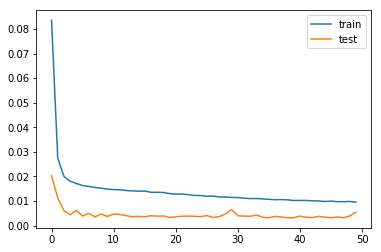

In [16]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [17]:
# Test the prediction of test data
y = model.predict(test_x)

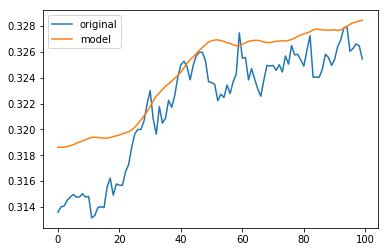

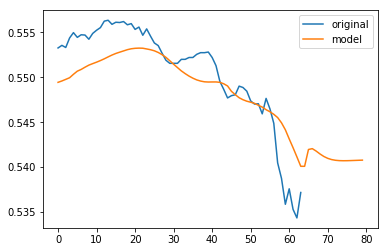

In [18]:
a = test_y[:,0]
b = y[:,0]
c = np.append(b, y[-1], axis=0)

# Show how the model fits the test data
pyplot.plot(a[:100], label='original')
pyplot.plot(b[:100], label='model')
pyplot.legend()
pyplot.show()

# Show how the model predicts data
pos = int(a.shape[0]-n_out*4)
pyplot.plot(a[pos:], label='original')
pyplot.plot(c[pos:], label='model')
pyplot.legend()
pyplot.show()


In [19]:
#Prediction on public data!
period = CONFIG['period']
import time
from urllib.request import urlopen
import json

# Download a live bitcoin price data set
def dl_X(now = None, points = n_lag, period = period, pair=CONFIG['pair']):
    if now == None:
        now = time.time() 
    end = now - now % period
    #print end, time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(end))
    start = end - points*period
    #print start, time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(start))
    url = "https://poloniex.com/public?command=returnChartData&currencyPair=%s&start=%d&end=%d&period=%d" % (pair, start, end, period)
    openUrl = urlopen(url)
    r = openUrl.read()
    openUrl.close()
    d = json.loads(r.decode())[-n_lag:]
    df = pd.DataFrame(d)
    original_columns=[u'close', u'date', u'high', u'low', u'open',u'volume']
    new_columns = ['Close','Timestamp','High','Low','Open','Volume']
    df = df.loc[:,original_columns]
    df.columns = new_columns
    
    return df

In [20]:
def predict(when=None):
    rt_df = dl_X(when)
    rt_values = rt_df.loc[:,columns].values
    rt_scaled = scaler.transform(rt_values)
    rt_x = rt_scaled.reshape((1, n_lag, n_features))
    print (rt_x.shape)
    return rt_scaled, model.predict(rt_x)

(1, 256, 4)


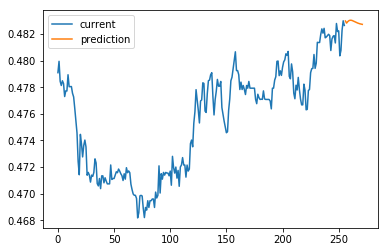

(1, 256, 4)


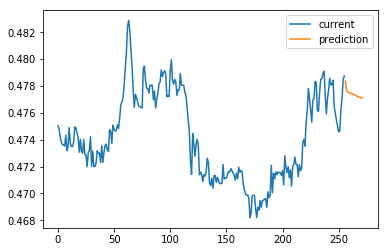

(1, 256, 4)


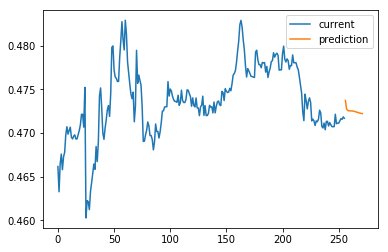

(1, 256, 4)


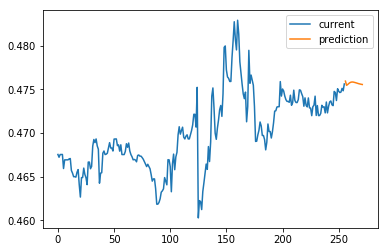

(1, 256, 4)


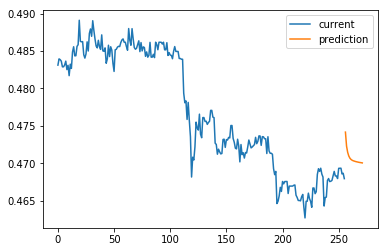

(1, 256, 4)


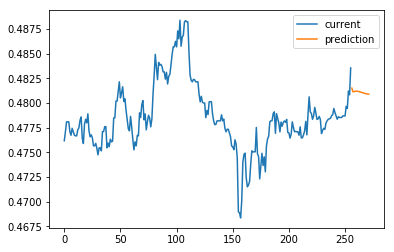

(1, 256, 4)


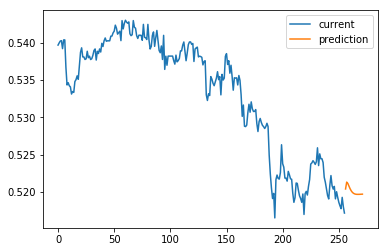

In [21]:
# do some now & past predictions
for t in [0, 100, 200, 300, 500, 1000, 2000]:
    rt_x, prediction = predict(time.time()-t*period)

    current = rt_x[:,0]
    prediction = prediction[0]

    pyplot.plot(current, label='current')

    # shift train predictions for plotting
    predictPlot = np.empty_like(current)
    predictPlot[:] = np.nan
    predictPlot = np.append(predictPlot, prediction)

    pyplot.plot(predictPlot, label='prediction')
    pyplot.legend()
    pyplot.show()

Sun, 01 Jul 2018 10:20:00 +0000
(1, 256, 4)


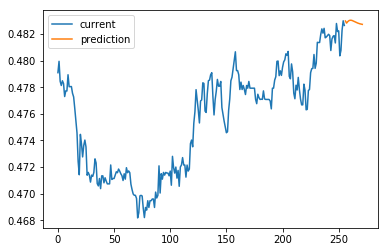

Sun, 01 Jul 2018 10:25:00 +0000
(1, 256, 4)


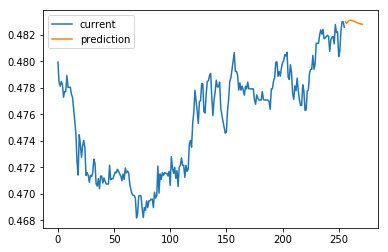

Sun, 01 Jul 2018 10:30:00 +0000
(1, 256, 4)


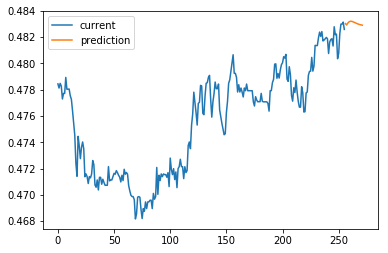

Sun, 01 Jul 2018 10:35:00 +0000
(1, 256, 4)


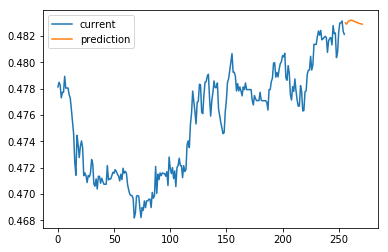

Sun, 01 Jul 2018 10:40:00 +0000
(1, 256, 4)


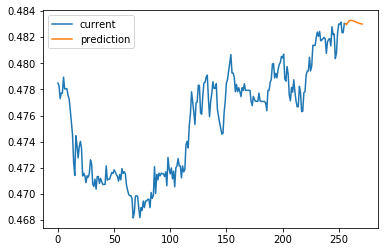

Sun, 01 Jul 2018 10:45:00 +0000
(1, 256, 4)


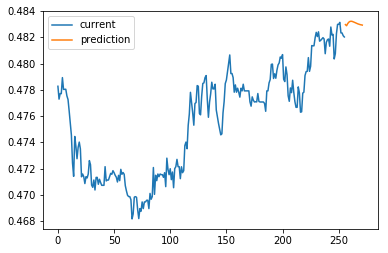

Sun, 01 Jul 2018 10:50:00 +0000
(1, 256, 4)


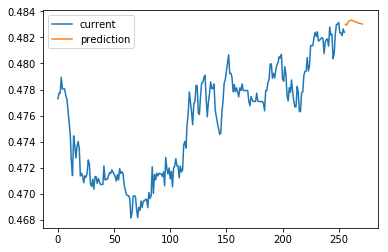

Sun, 01 Jul 2018 10:55:00 +0000
(1, 256, 4)


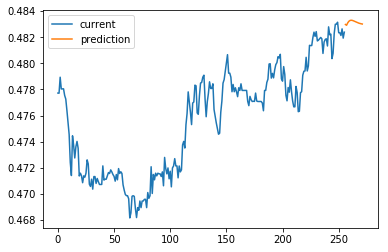

Sun, 01 Jul 2018 11:00:00 +0000
(1, 256, 4)


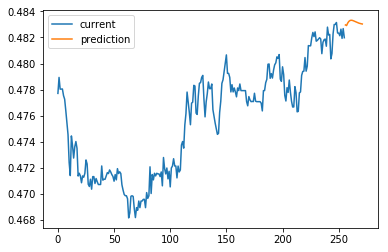

Sun, 01 Jul 2018 11:05:00 +0000
(1, 256, 4)


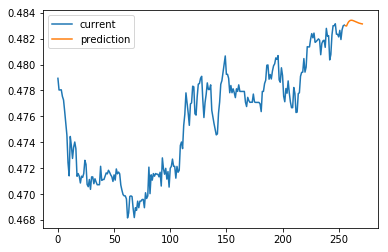

Sun, 01 Jul 2018 11:10:00 +0000
(1, 256, 4)


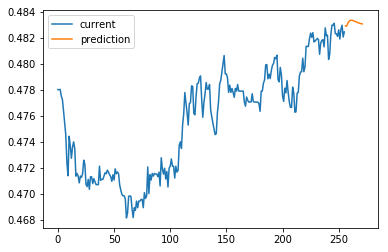

Sun, 01 Jul 2018 11:15:00 +0000
(1, 256, 4)


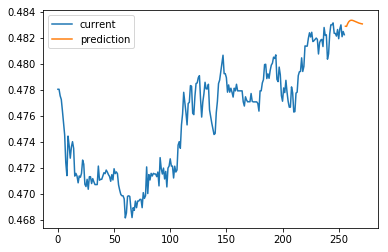

Sun, 01 Jul 2018 11:20:00 +0000
(1, 256, 4)


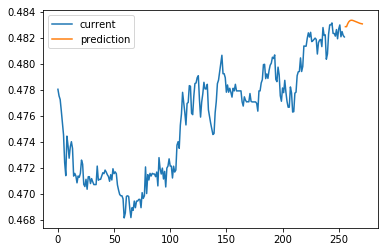

Sun, 01 Jul 2018 11:25:00 +0000
(1, 256, 4)


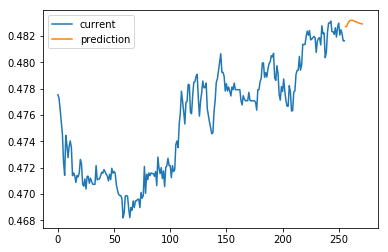

Sun, 01 Jul 2018 11:30:00 +0000
(1, 256, 4)


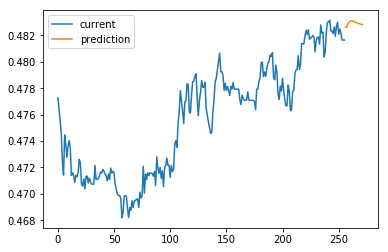

Sun, 01 Jul 2018 11:35:00 +0000
(1, 256, 4)


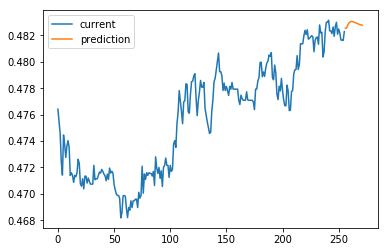

Sun, 01 Jul 2018 11:40:00 +0000
(1, 256, 4)


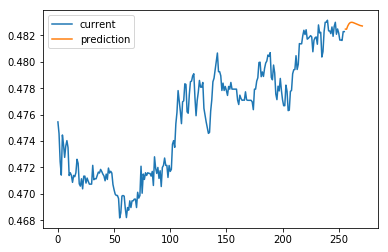

Sun, 01 Jul 2018 11:45:00 +0000
(1, 256, 4)


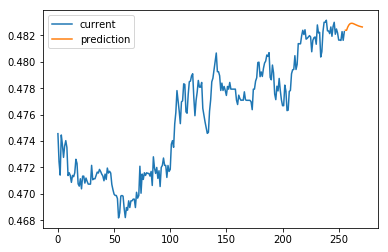

Sun, 01 Jul 2018 11:50:00 +0000
(1, 256, 4)


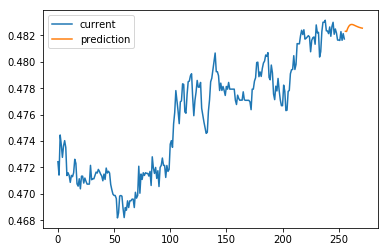

Sun, 01 Jul 2018 11:55:00 +0000
(1, 256, 4)


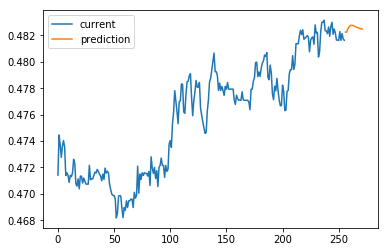

KeyboardInterrupt: 

In [22]:
#Prediction on live data!
starttime=time.time()
while True:
    now = time.time() 
    end = now - now % period
    print (time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(end)))
    rt_x, prediction = predict()

    current = rt_x[:,0]
    prediction = prediction[0]

    pyplot.plot(current, label='current')

    # shift train predictions for plotting
    predictPlot = np.empty_like(current)
    predictPlot[:] = np.nan
    predictPlot = np.append(predictPlot, prediction)

    pyplot.plot(predictPlot, label='prediction')
    pyplot.legend()
    pyplot.show()

    time.sleep(period - ((time.time() - starttime) % period))